<a href="https://colab.research.google.com/github/Navar-Schueler/1/blob/main/Bachelor_Thesis_Time_Series_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('seaborn-whitegrid')

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Selected stocks
stocks = ["ADS", "ALV", "BAS", "BAYN", "BMW", "HEN3", "RWE", "SIE", "VOW3", 
          "SAP", "MUV2","DTE", "MBG", "FME", "EOAN", "DPW", "DB1", "MRK", "FRE",
          "IFX"]

In [ ]:
#Load data 
df_ = {}
for i in stocks:
    df_[i] = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/" + i + ".csv", index_col="Date", parse_dates=["Date"])

In [ ]:
#Splitting the data set into training and test data set
def split(dataframe, border, col):
    return dataframe.loc[:border,col], dataframe.loc[border:,col]

df_new = {}
for i in stocks:
    df_new[i] = {}
    df_new[i]["Train"], df_new[i]["Test"] = split(df_[i],"2018-10-02", "Close")

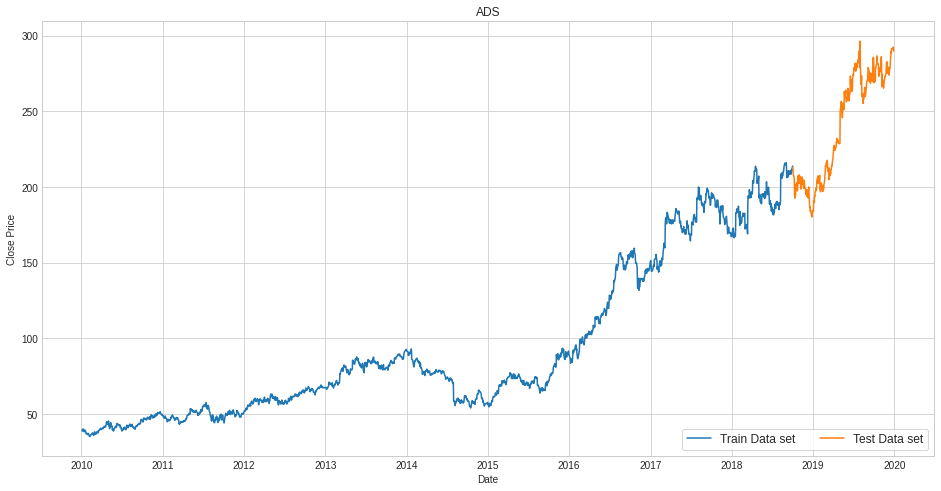

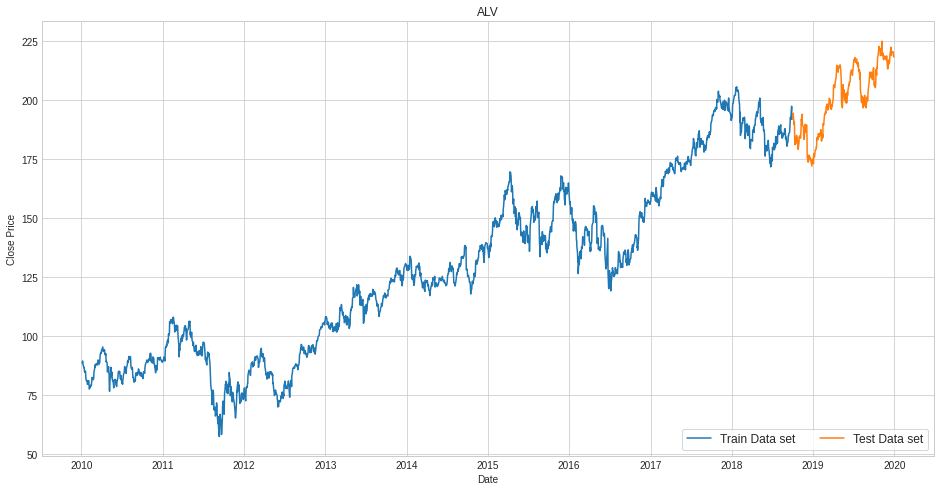

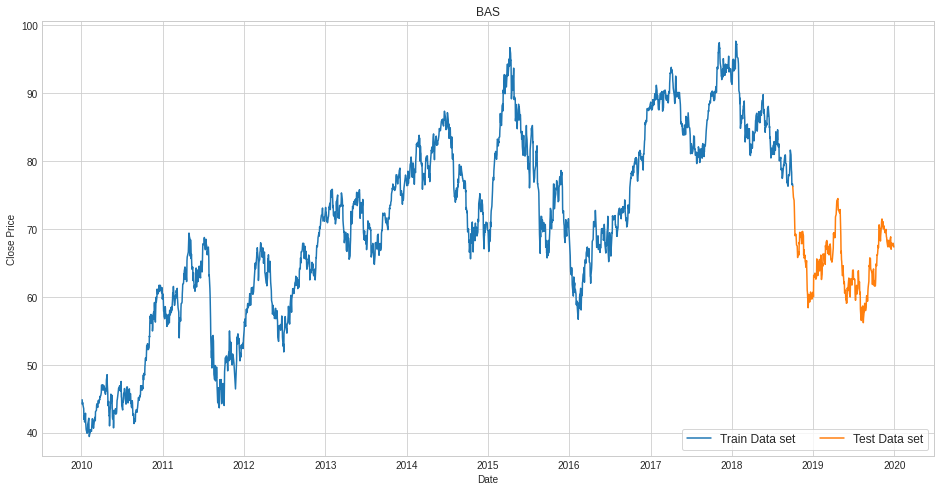

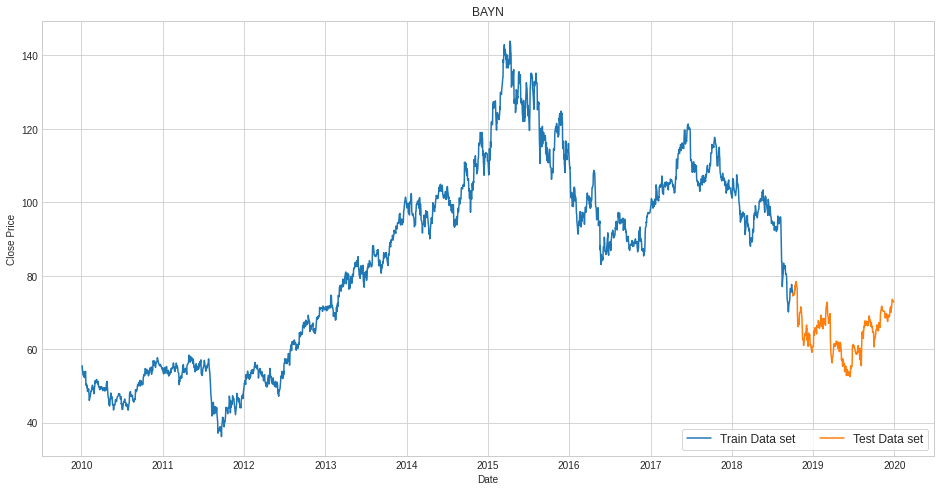

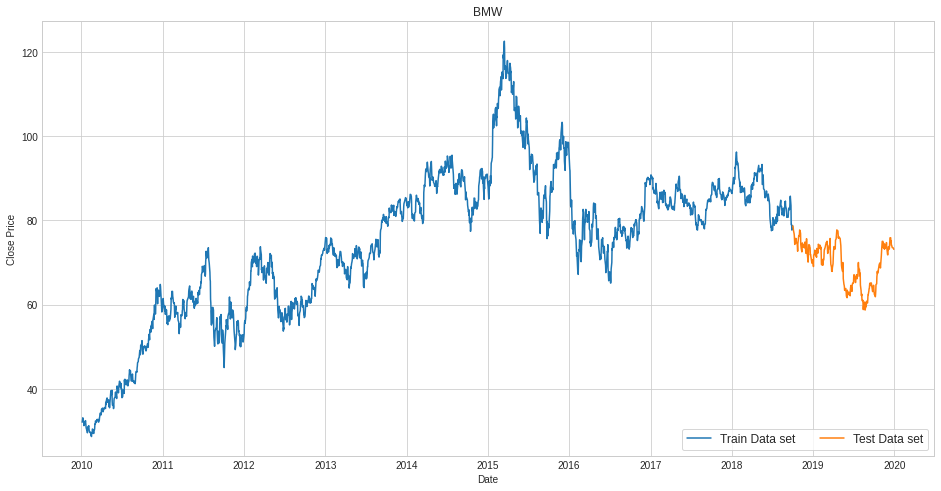

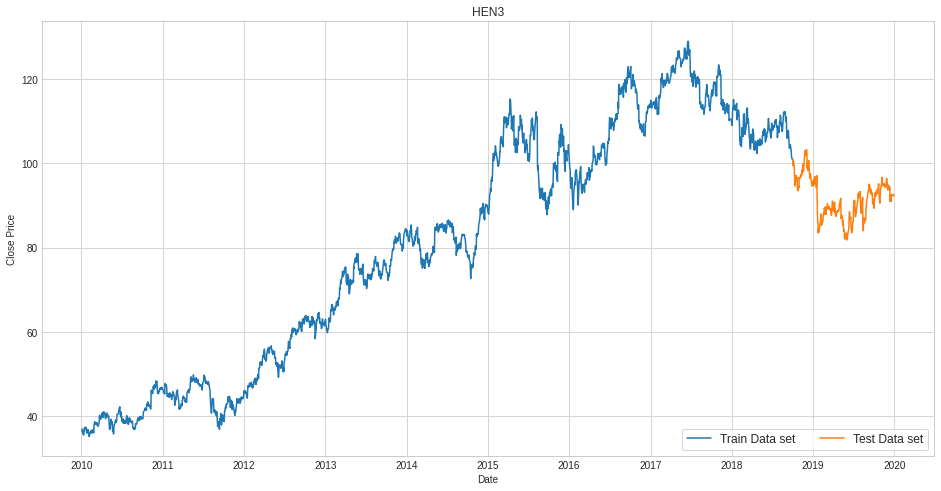

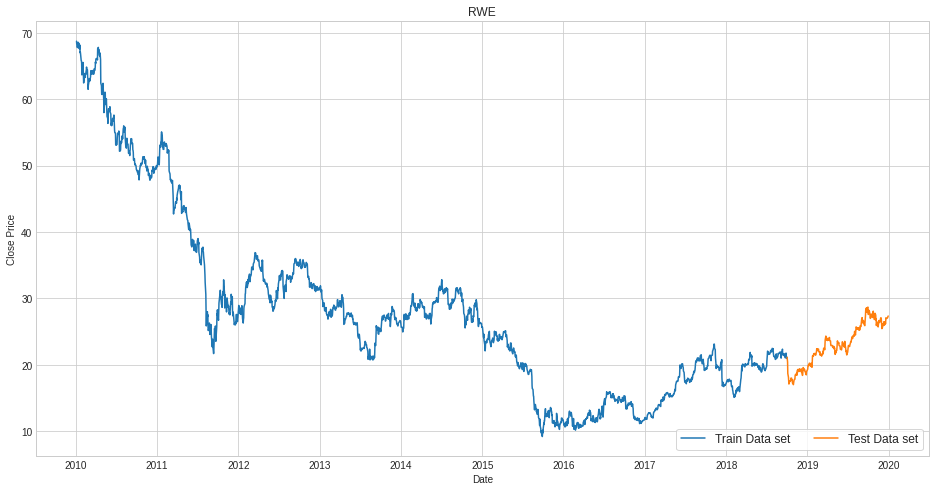

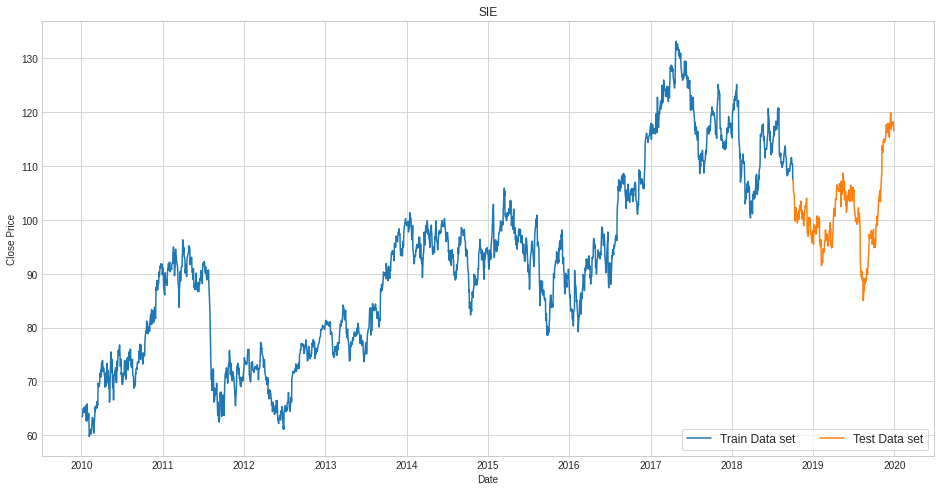

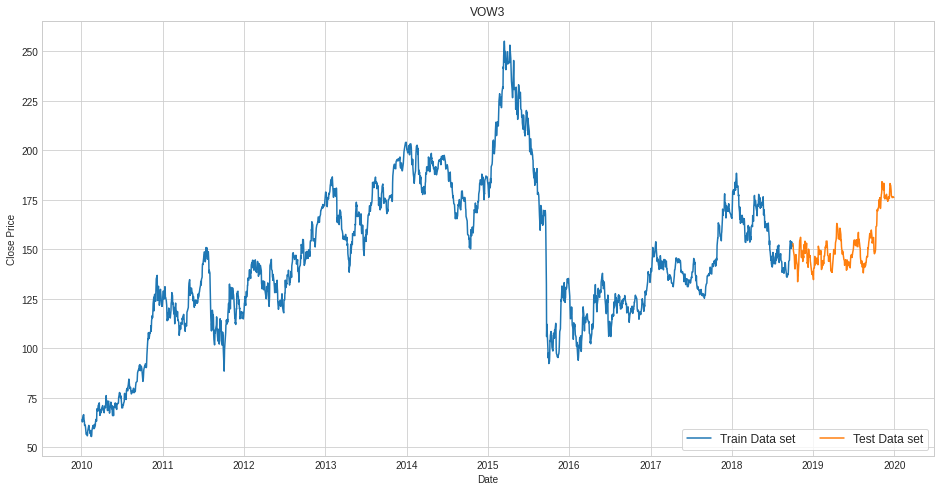

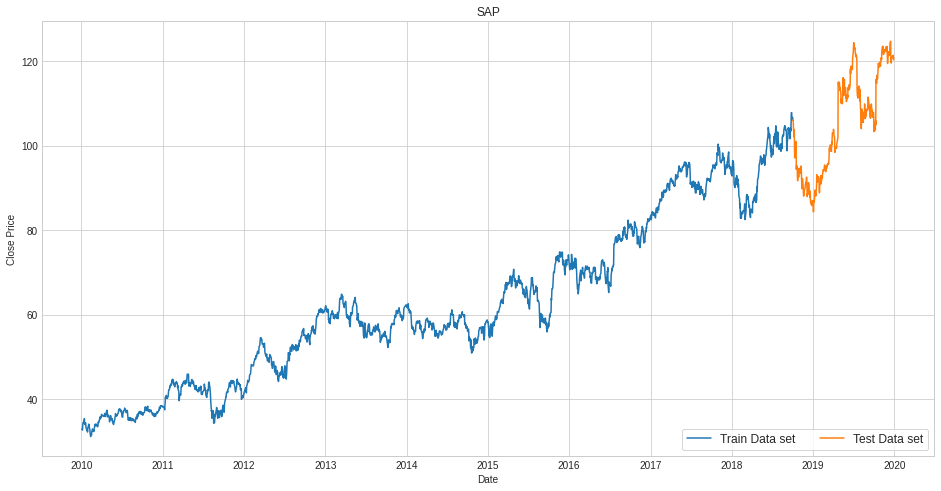

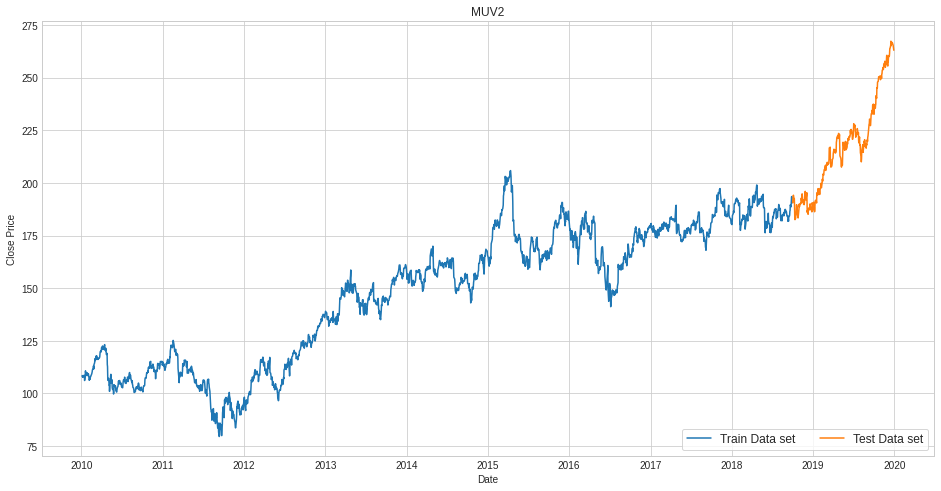

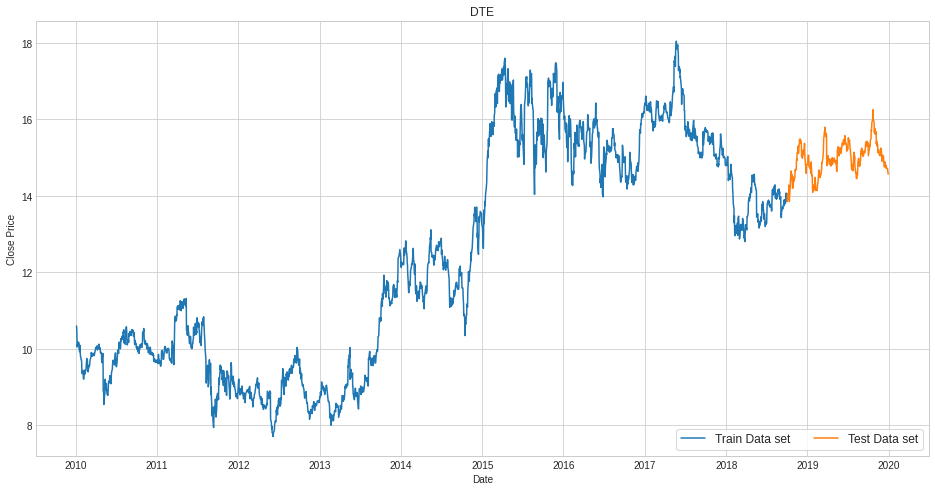

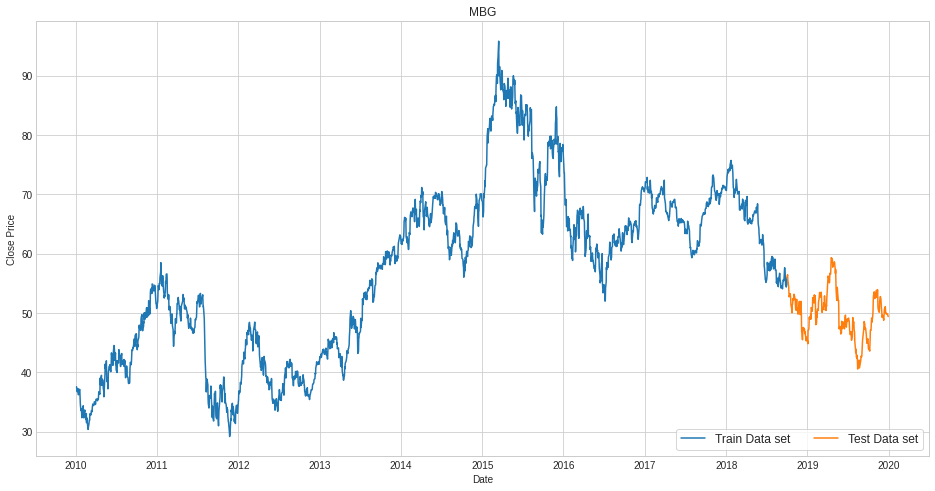

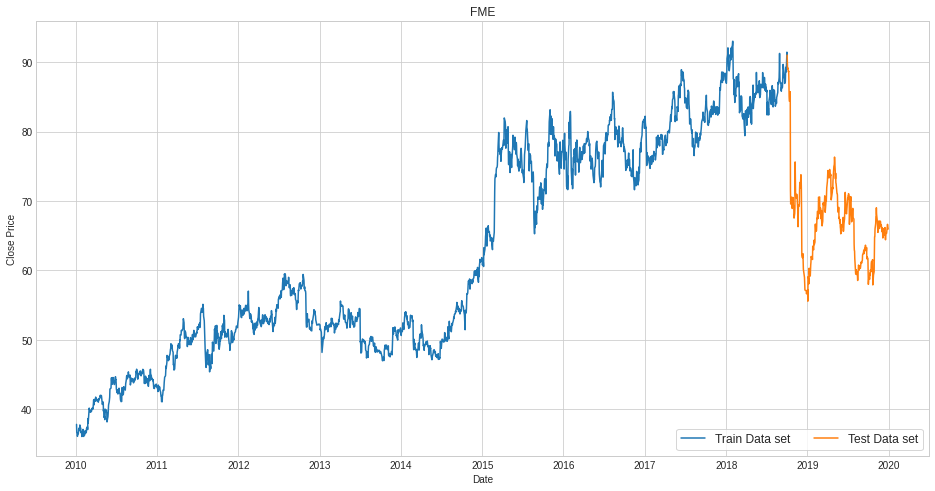

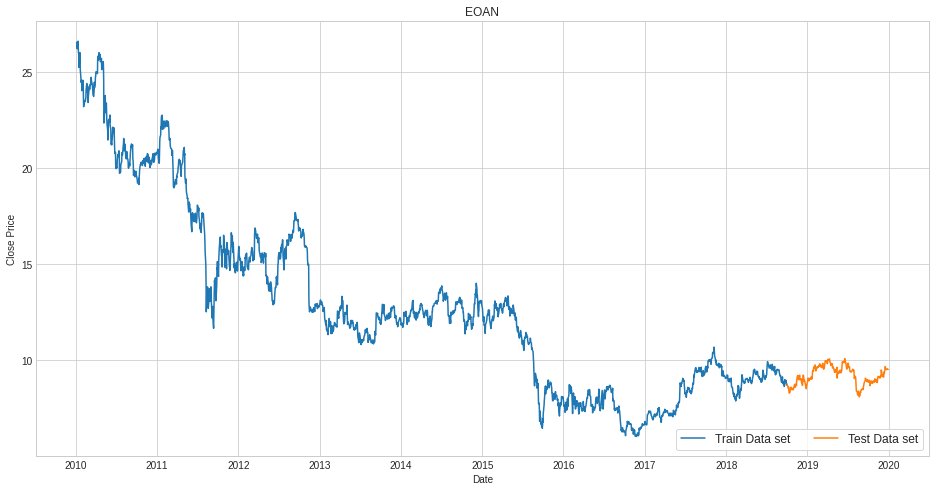

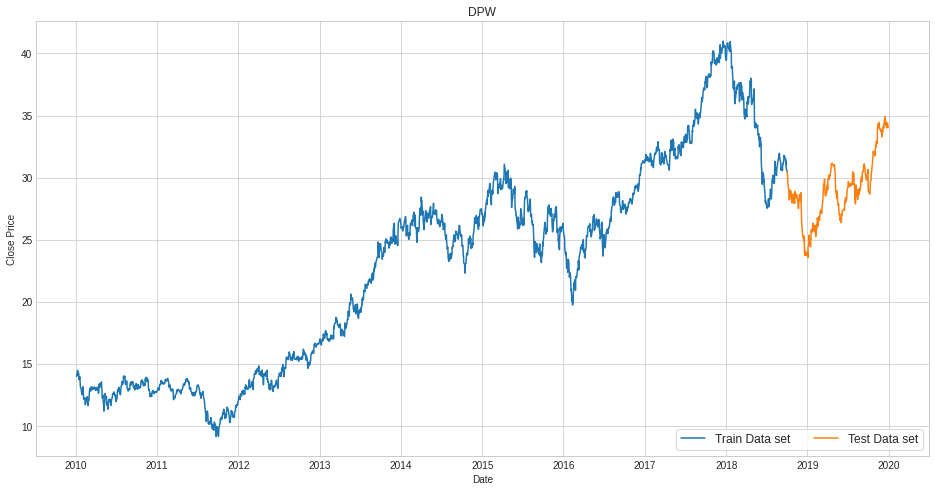

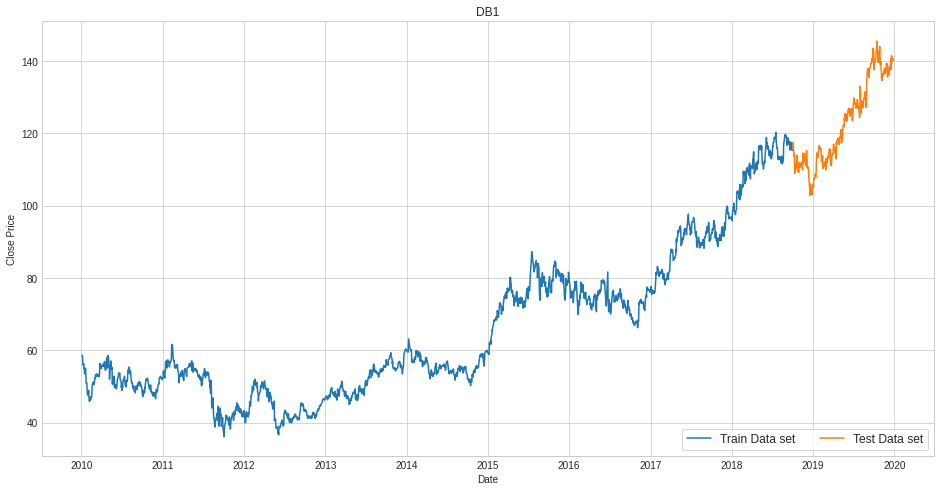

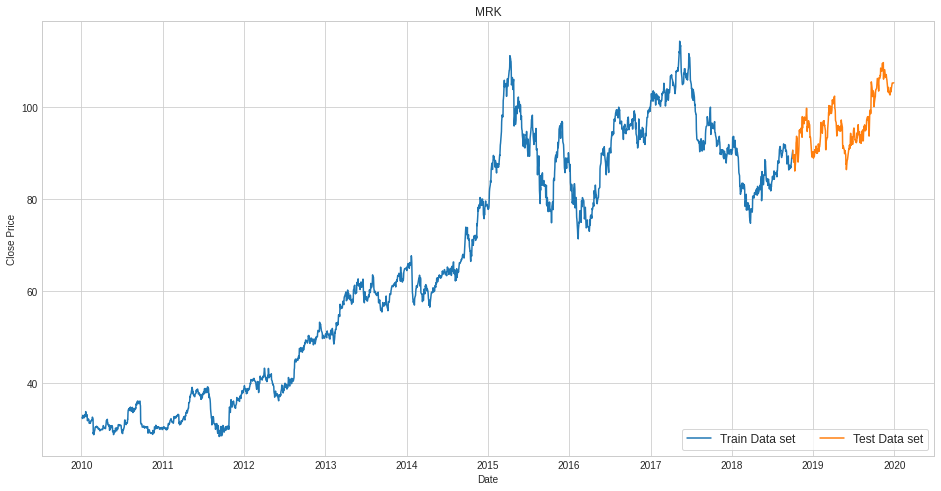

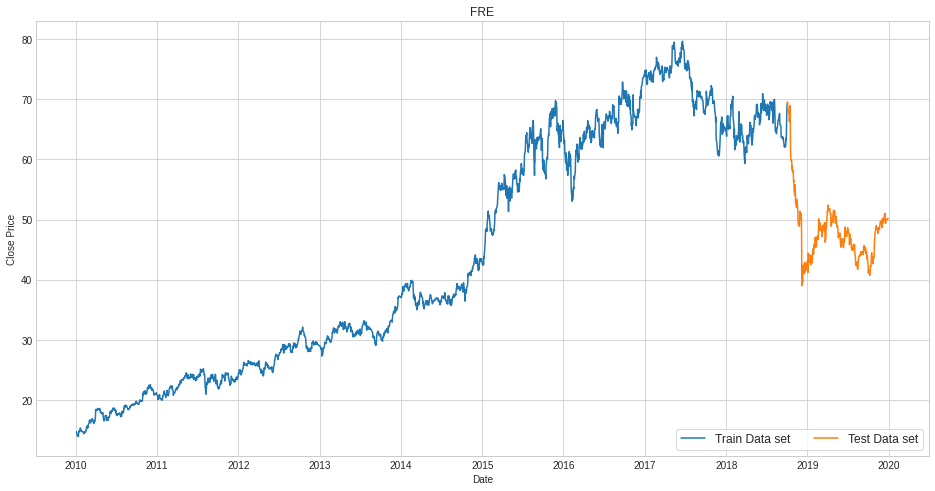

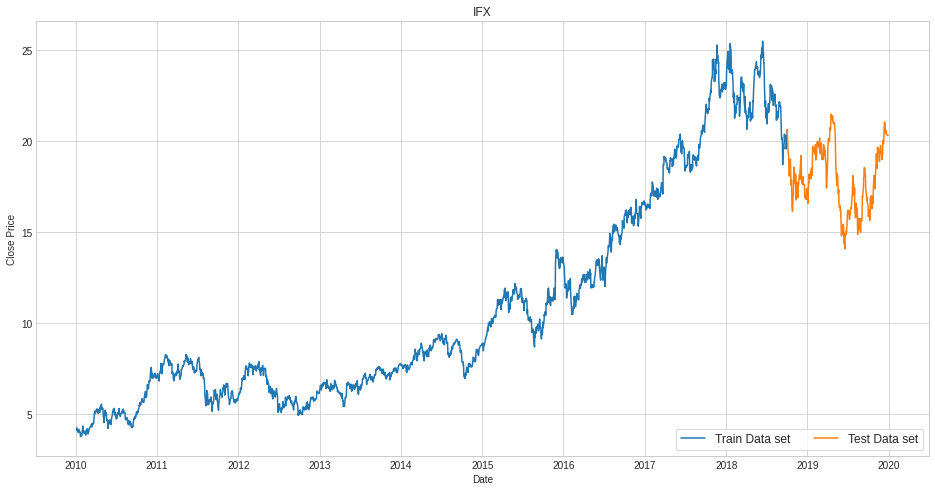

In [ ]:
#Stock charts
for i in stocks:
    plt.figure(figsize=(16,8))
    plt.plot(df_new[i]["Train"], label = "Train Data set")
    plt.plot(df_new[i]["Test"], label = "Test Data set")
    plt.ylabel("Close Price")
    plt.xlabel("Date")
    plt.legend(ncol=2, loc="lower right",frameon=True,shadow=False,fontsize=12)
    plt.title(i )

In [ ]:
#Range transformation for better prediction results
transform_train = {}
transform_test = {}
scaler = {}
scaler1 = {}
for stock in stocks:
    sc = MinMaxScaler(feature_range=(0,1)) #scale train
    sc1 = MinMaxScaler(feature_range=(0,1)) #scale test
    a0 = np.array(df_new[stock]["Train"])
    a1 = np.array(df_new[stock]["Test"])
    a0 = a0.reshape(a0.shape[0],1)
    a1 = a1.reshape(a1.shape[0],1)
    transform_train[stock] = sc.fit_transform(a0) 
    scaler[stock] = sc
    transform_test[stock] = sc1.fit_transform(a1)
    scaler1[stock] = sc
    
del a0
del a1


In [ ]:
#Creating a Lookback for the RNNs of 60 trading days
trainset = {}
testset = {}
for j in stocks:
    trainset[j] = {}
    X_train = []
    y_train = []
    for i in range(60,2226):
        X_train.append(transform_train[j][i-60:i,0])
        y_train.append(transform_train[j][i,0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    trainset[j]["X"] = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
    trainset[j]["y"] = y_train
    
    testset[j] = {}
    X_test = []
    y_test = []    
    for i in range(60, 311):
        X_test.append(transform_test[j][i-60:i,0])
        y_test.append(transform_test[j][i,0])
    X_test, y_test = np.array(X_test), np.array(y_test)
    testset[j]["X"] = np.reshape(X_test, (X_test.shape[0], X_train.shape[1], 1))
    testset[j]["y"] = y_test

In [ ]:
#Test the shape of the data sets 
arr_buff = []
for i in stocks:
    buff = {}
    buff["X_train"] = trainset[i]["X"].shape
    buff["y_train"] = trainset[i]["y"].shape
    buff["X_test"] = testset[i]["X"].shape
    buff["y_test"] = testset[i]["y"].shape
    arr_buff.append(buff)

#pd.DataFrame(arr_buff, index=stocks)

In [ ]:
#Apply the LSTM 
%%time
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
#regressor.add(LSTM(units=50, return_sequences=True))
#regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='adam', loss='mean_squared_error')
# Fitting to the training set
for i in stocks:
    print("Fitting to", i)
    regressor.fit(trainset[i]["X"], trainset[i]["y"], epochs=30, batch_size=32)

Fitting to ADS
Epoch 1/30
68/68 [==============================] - 8s 58ms/step - loss: 0.0148
Epoch 2/30
68/68 [==============================] - 4s 57ms/step - loss: 0.0035
Epoch 3/30
68/68 [==============================] - 4s 56ms/step - loss: 0.0026
Epoch 4/30
68/68 [==============================] - 4s 56ms/step - loss: 0.0022
Epoch 5/30
68/68 [==============================] - 4s 57ms/step - loss: 0.0020
Epoch 6/30
68/68 [==============================] - 4s 58ms/step - loss: 0.0022
Epoch 7/30
68/68 [==============================] - 4s 56ms/step - loss: 0.0021
Epoch 8/30
68/68 [==============================] - 4s 56ms/step - loss: 0.0022
Epoch 9/30
68/68 [==============================] - 4s 57ms/step - loss: 0.0023
Epoch 10/30
68/68 [==============================] - 4s 56ms/step - loss: 0.0021
Epoch 11/30
68/68 [==============================] - 4s 56ms/step - loss: 0.0018
Epoch 12/30
68/68 [==============================] - 4s 56ms/step - loss: 0.0017
Epoch 13/30
68/68 [===

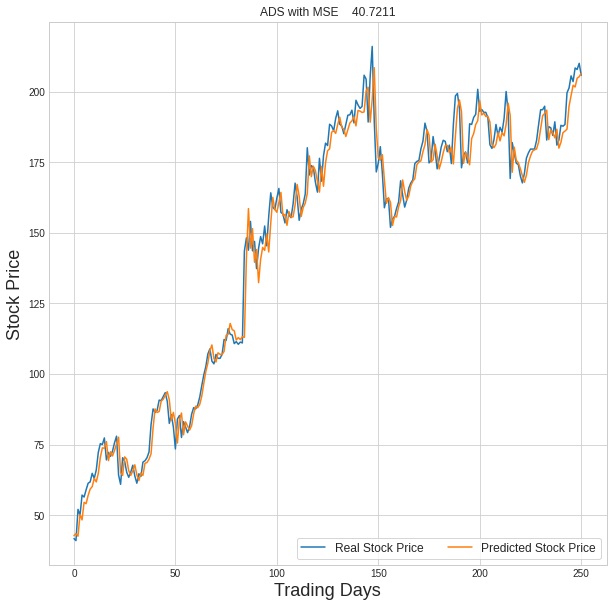

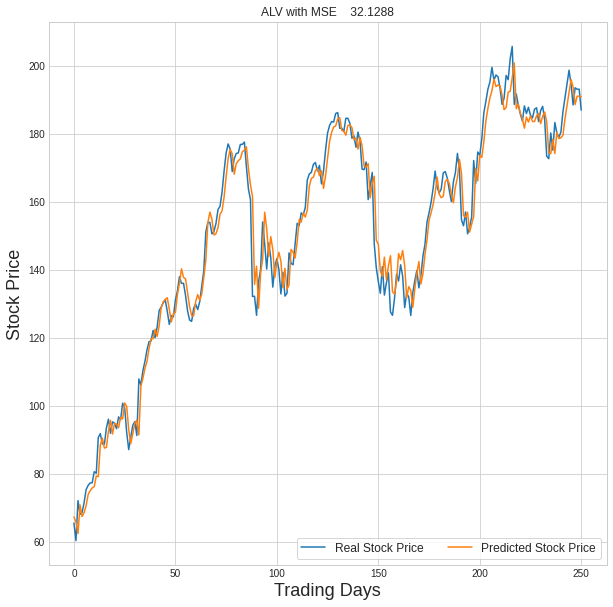

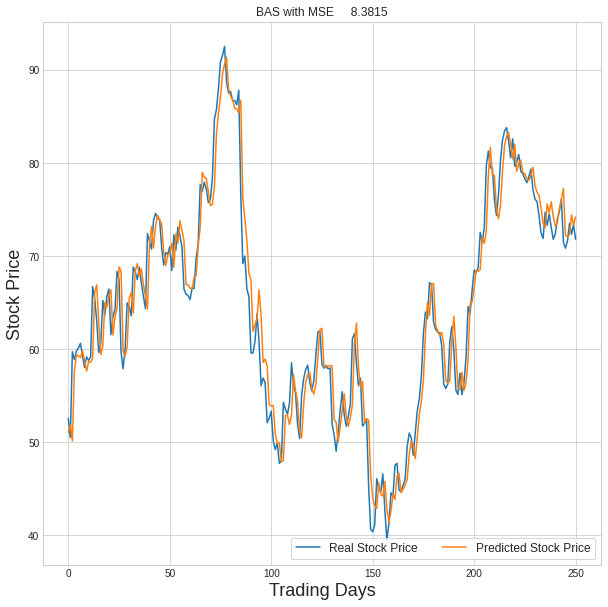

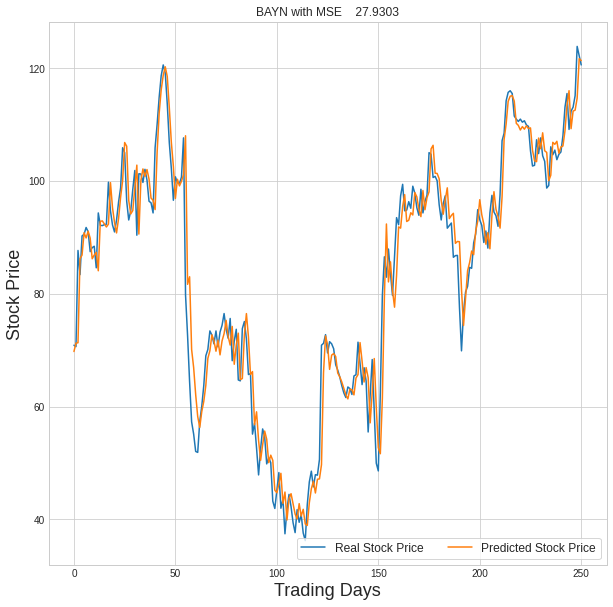

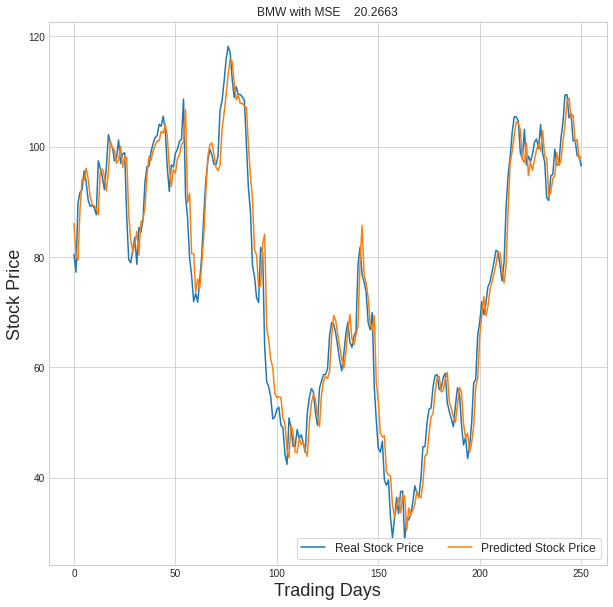

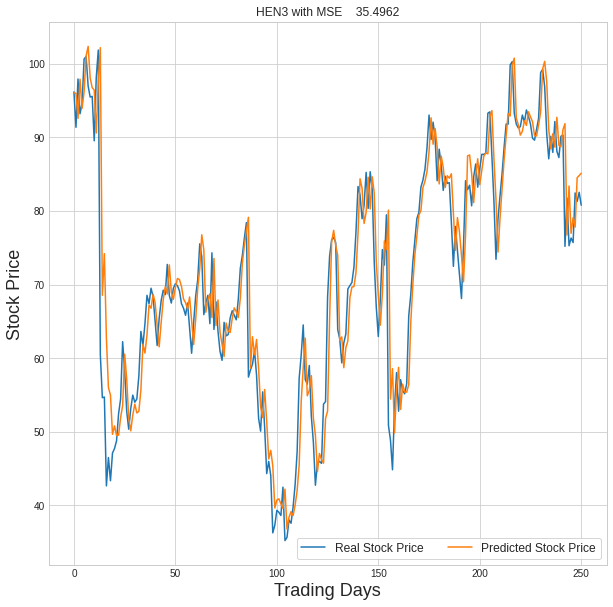

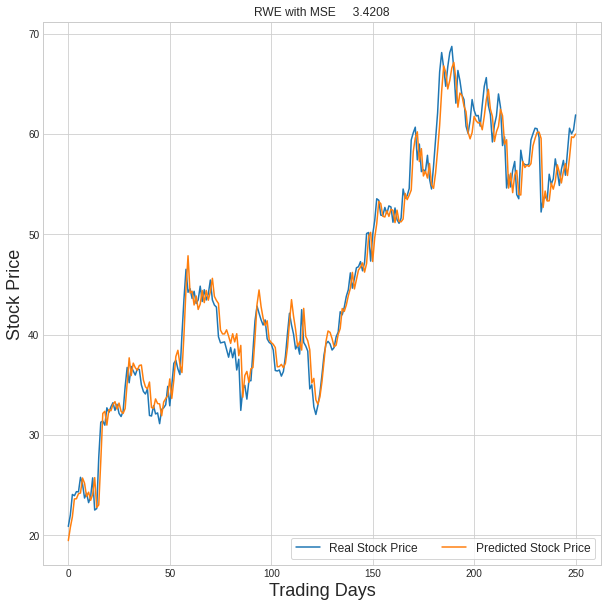

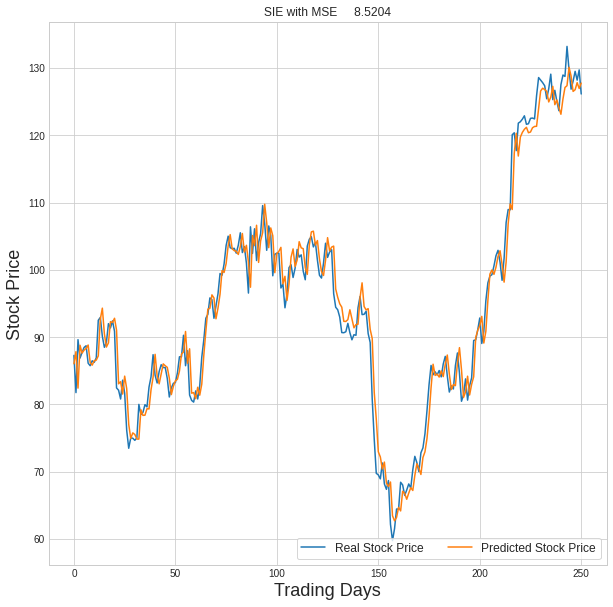

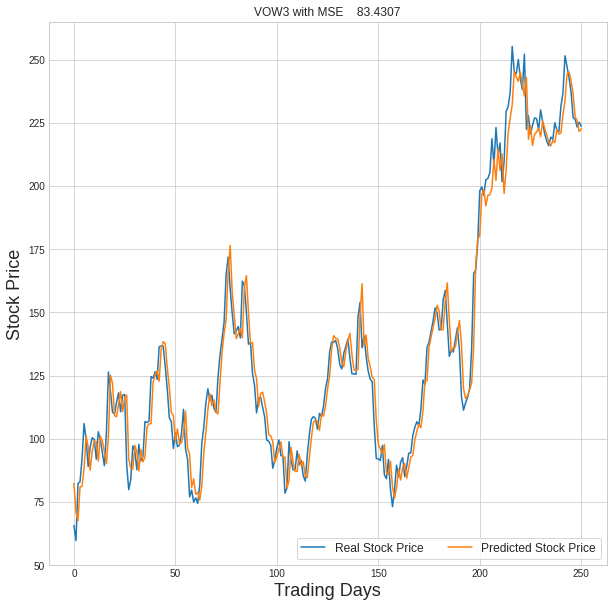

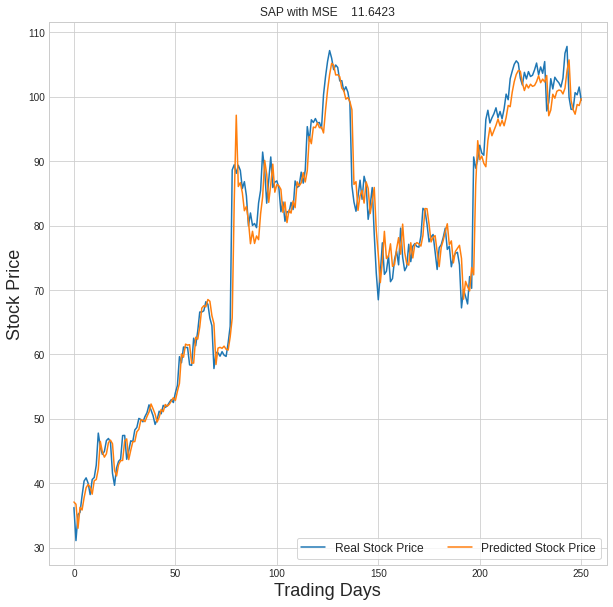

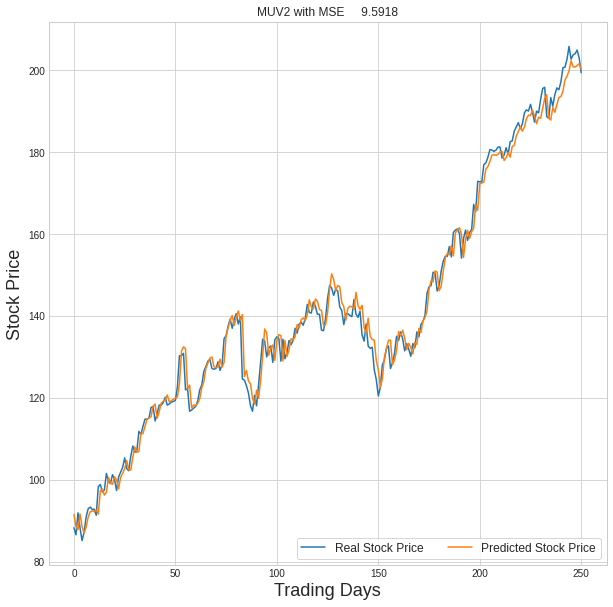

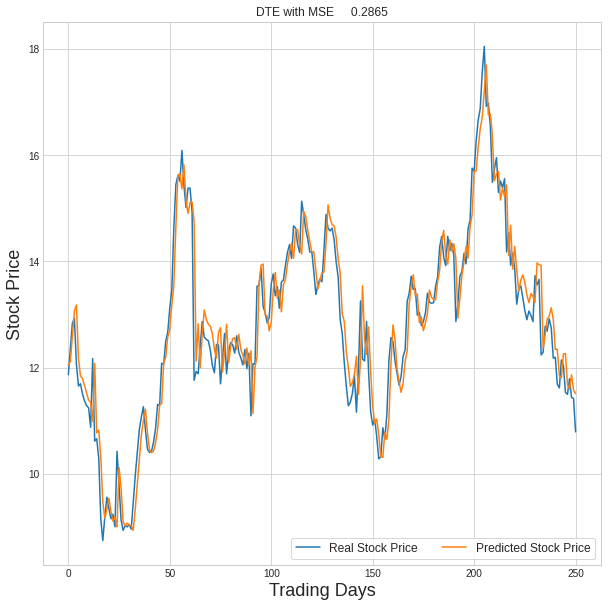

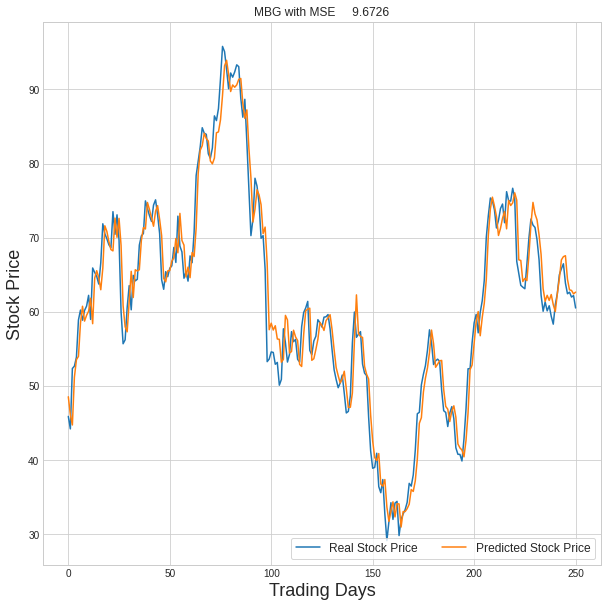

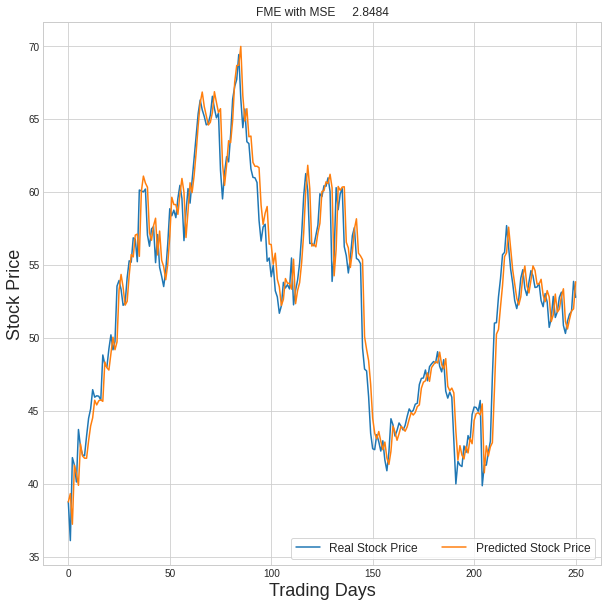

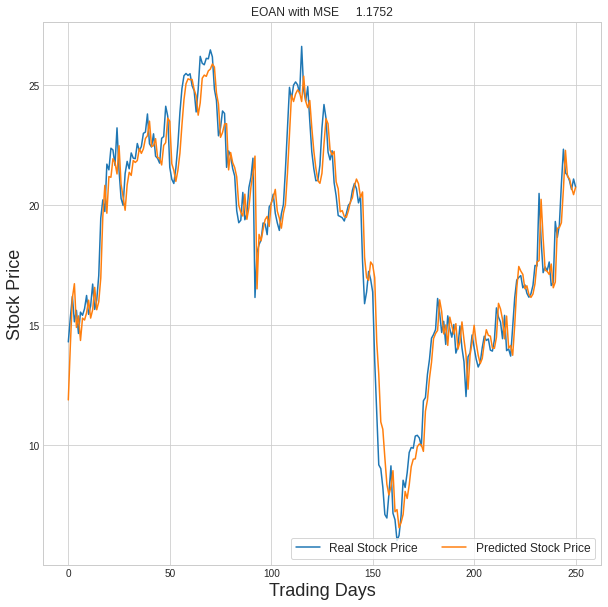

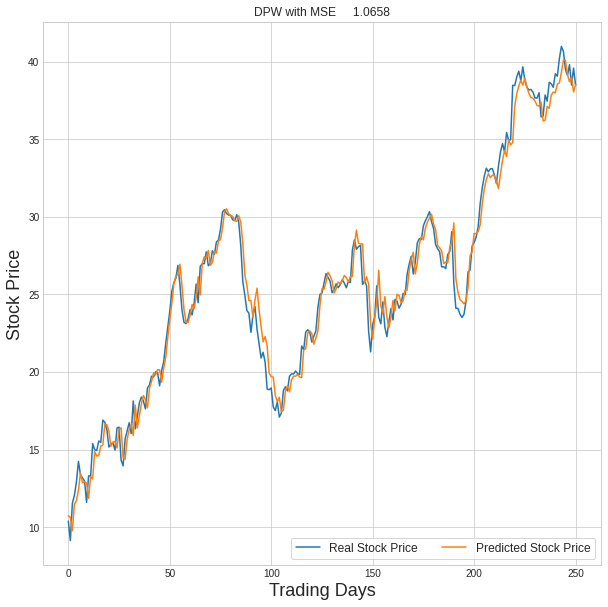

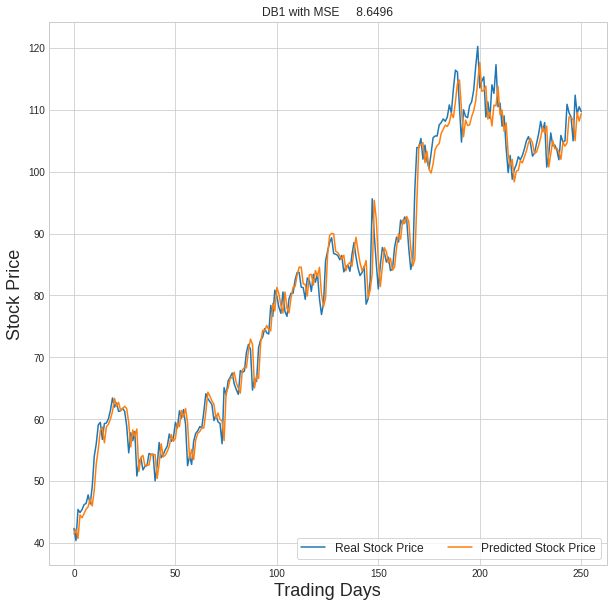

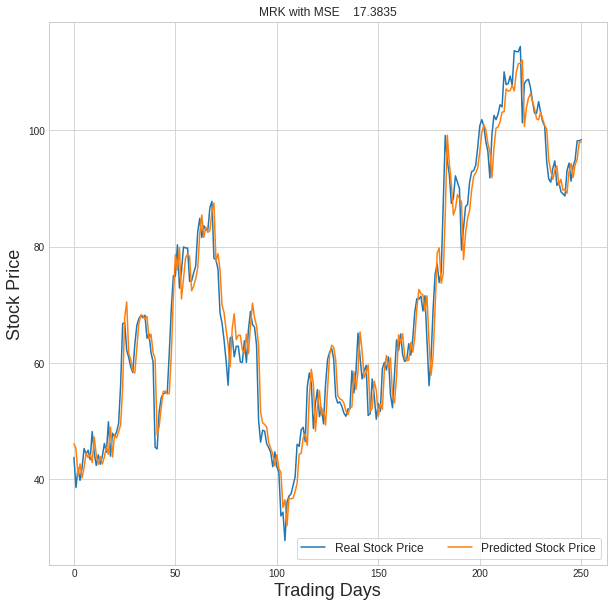

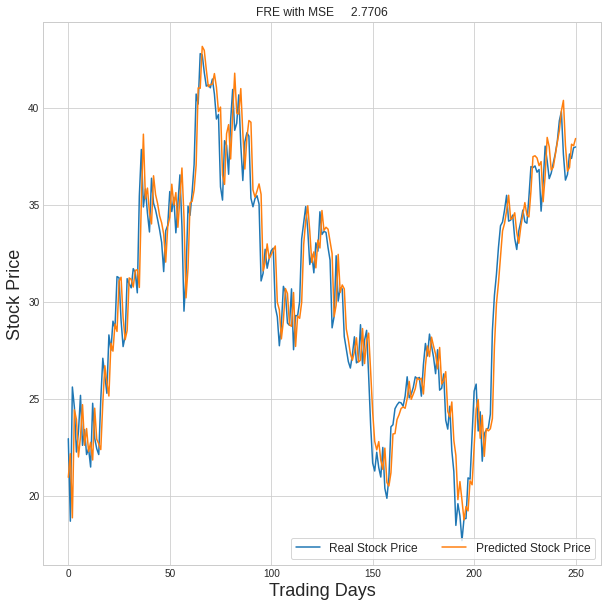

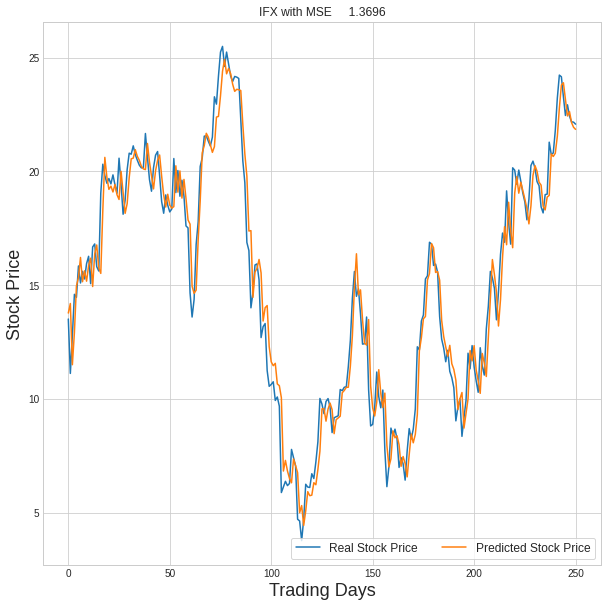

In [ ]:
MSE_LSTM = 0
pred_result = {}
plt.style.use('seaborn-whitegrid')
for i in stocks:
    y_true = scaler1[i].inverse_transform(testset[i]["y"].reshape(-1,1))
    y_pred = scaler1[i].inverse_transform(regressor.predict(testset[i]["X"]))
    MSE = mean_squared_error(y_true, y_pred)
    MSE_LSTM += MSE
    pred_result[i] = {}
    pred_result[i]["True"] = y_true
    pred_result[i]["Pred"] = y_pred
    
    plt.figure(figsize=(10,10))
    plt.title("{} with MSE {:10.4f}".format(i,MSE))
    plt.xlabel('Trading Days', fontsize=18)
    plt.ylabel('Stock Price', fontsize=18)
    plt.plot(y_true, label = "Real Stock Price")
    plt.plot(y_pred, label = "Predicted Stock Price")
    plt.legend(ncol=2, loc="lower right",frameon=True,shadow=False,fontsize=12)
    plt.show()



In [ ]:
#Apply the GRU 
%%time
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
#regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
#regressorGRU.add(Dropout(0.2))
# Third GRU layer
#regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
#regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
for i in stocks:
    print("Fitting to", i)
    regressorGRU.fit(trainset[i]["X"], trainset[i]["y"],epochs=30,batch_size=32)

Fitting to ADS
Epoch 1/30


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


68/68 [==============================] - 5s 38ms/step - loss: 0.0378
Epoch 2/30
68/68 [==============================] - 3s 37ms/step - loss: 0.0027
Epoch 3/30
68/68 [==============================] - 2s 36ms/step - loss: 0.0024
Epoch 4/30
68/68 [==============================] - 2s 37ms/step - loss: 0.0019
Epoch 5/30
68/68 [==============================] - 2s 37ms/step - loss: 0.0018
Epoch 6/30
68/68 [==============================] - 2s 36ms/step - loss: 0.0017
Epoch 7/30
68/68 [==============================] - 2s 36ms/step - loss: 0.0017
Epoch 8/30
68/68 [==============================] - 2s 36ms/step - loss: 0.0015
Epoch 9/30
68/68 [==============================] - 2s 36ms/step - loss: 0.0015
Epoch 10/30
68/68 [==============================] - 2s 36ms/step - loss: 0.0015
Epoch 11/30
68/68 [==============================] - 2s 36ms/step - loss: 0.0015
Epoch 12/30
68/68 [==============================] - 2s 36ms/step - loss: 0.0014
Epoch 13/30
68/68 [=============================

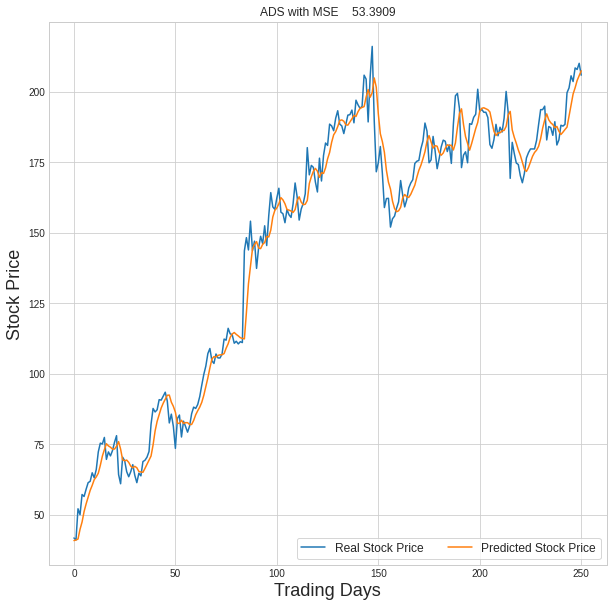

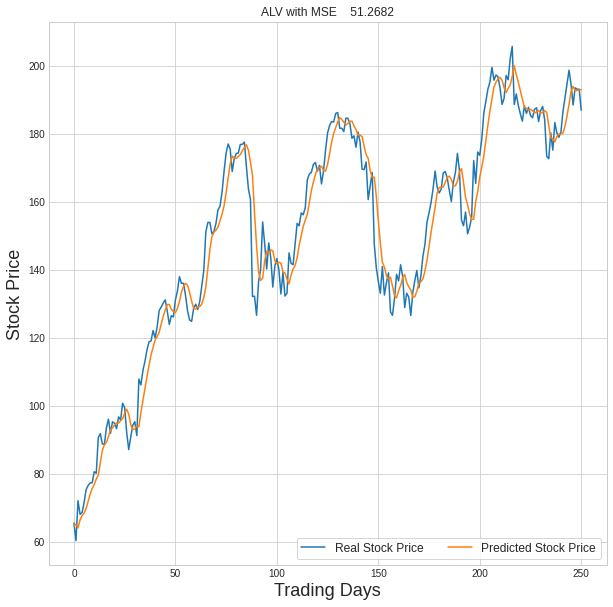

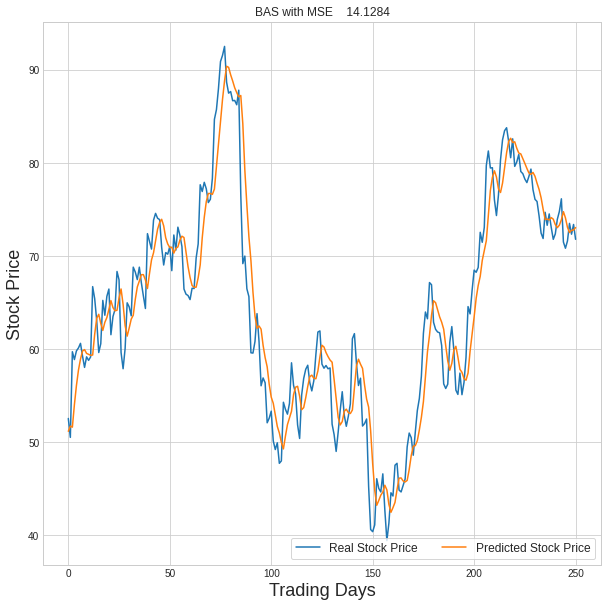

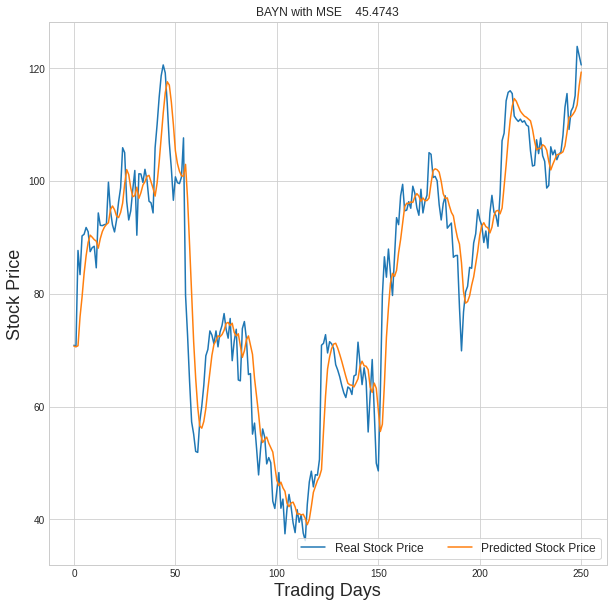

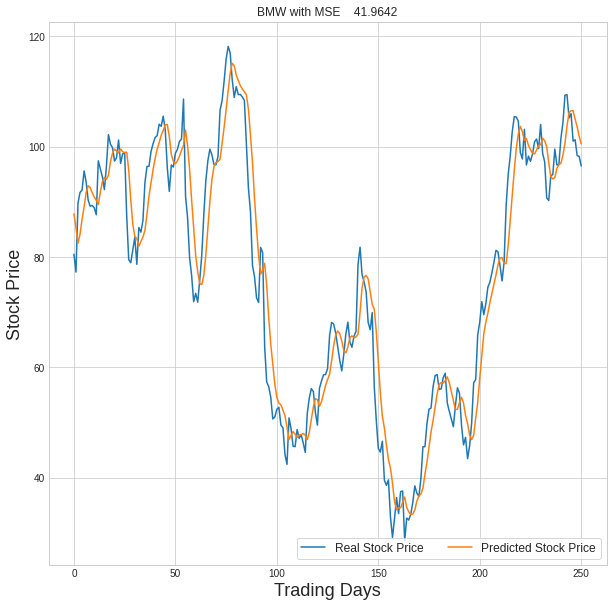

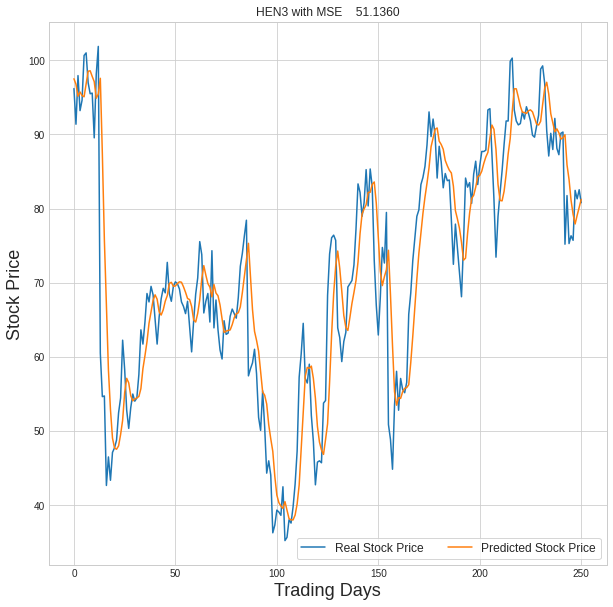

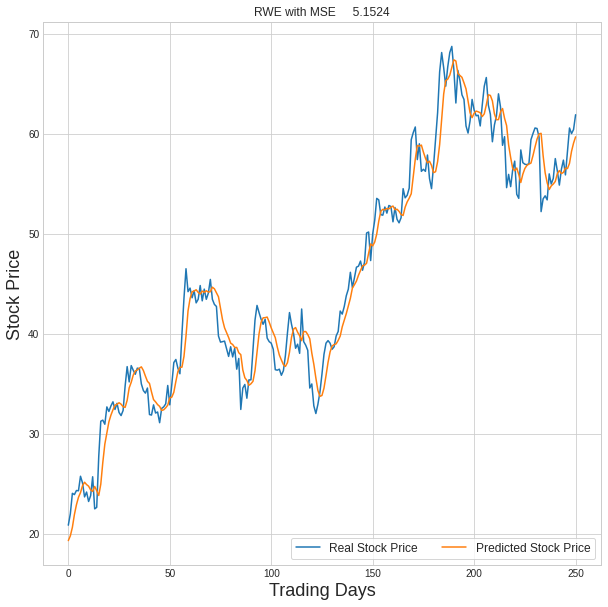

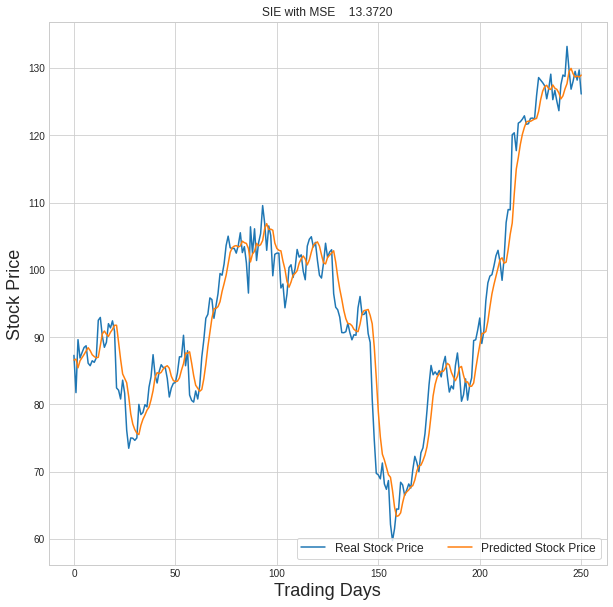

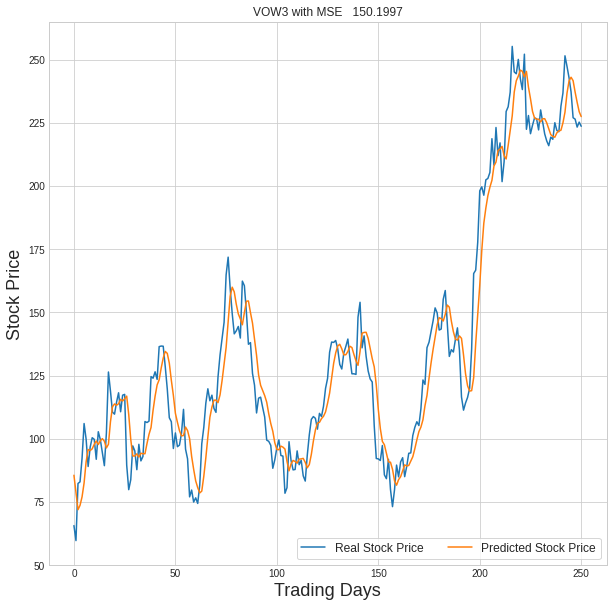

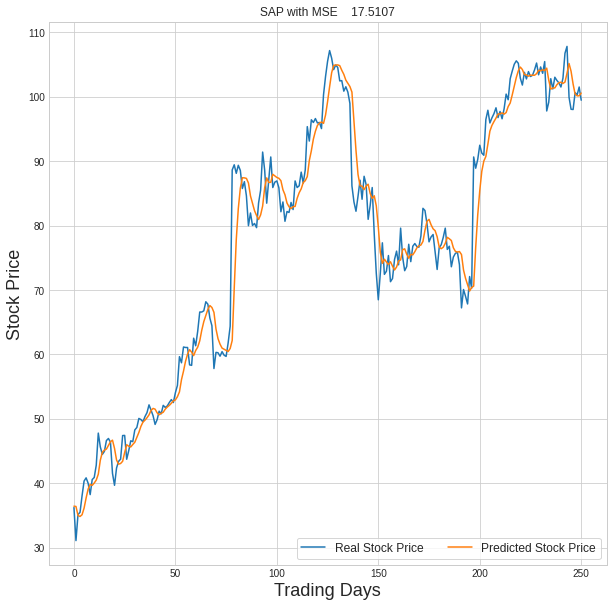

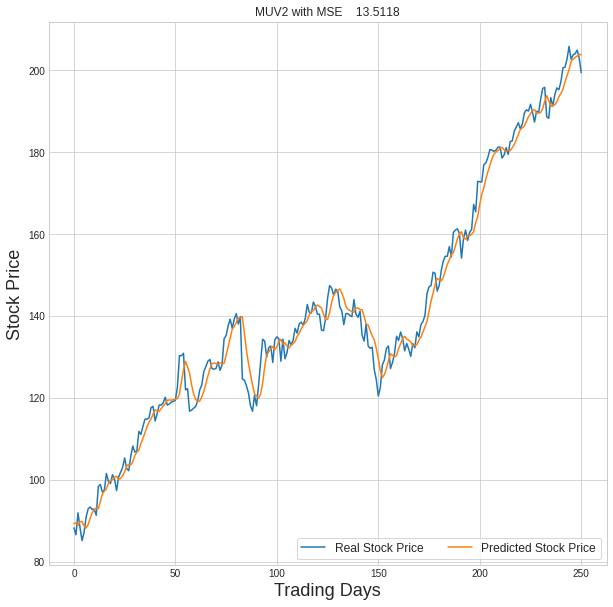

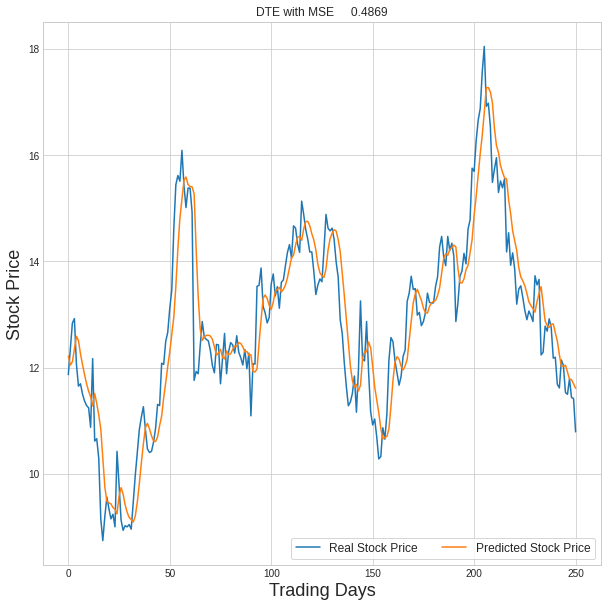

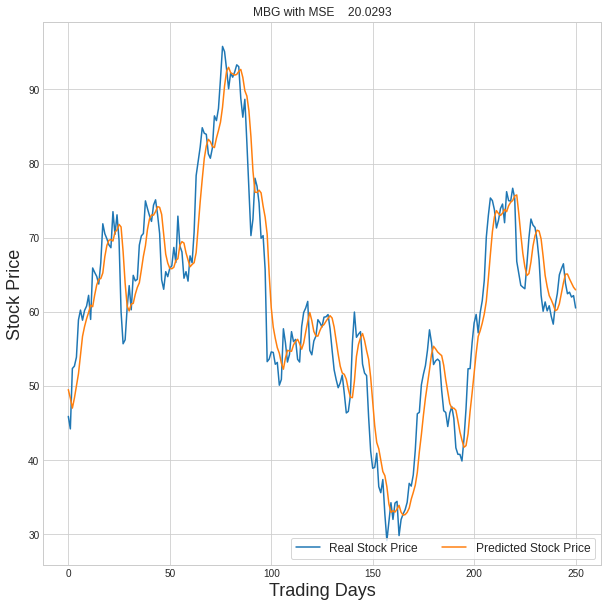

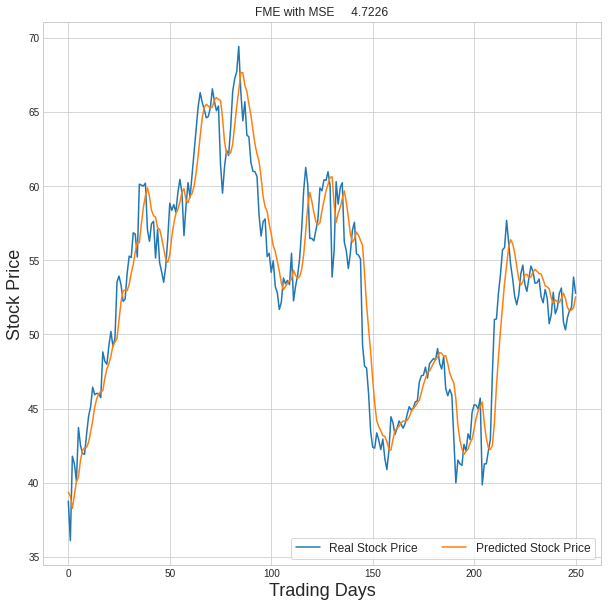

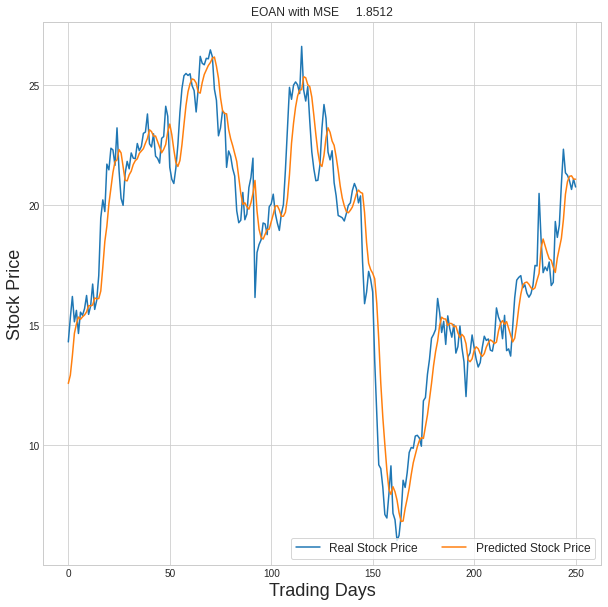

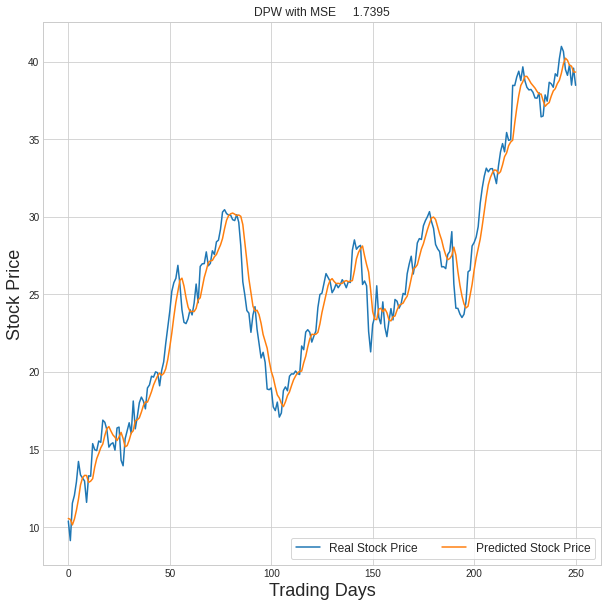

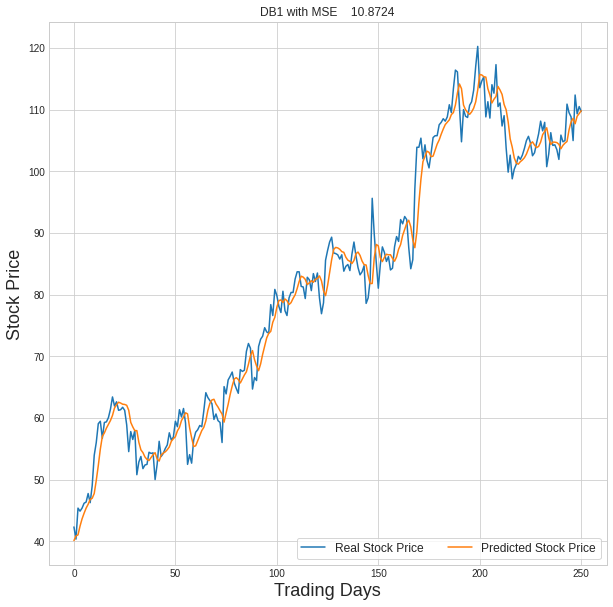

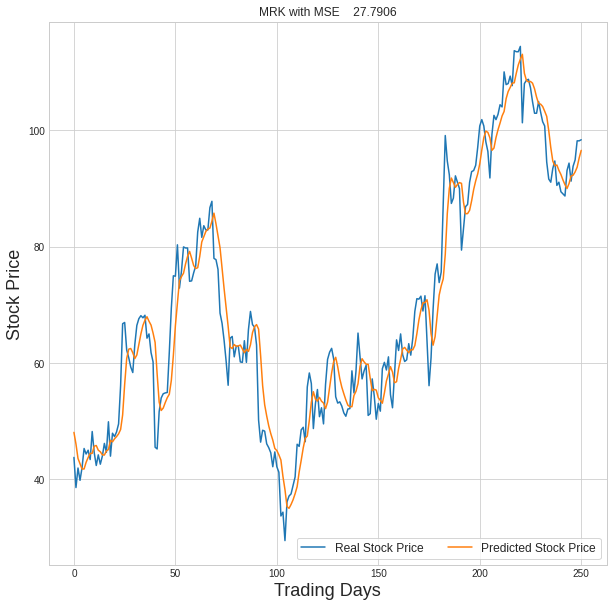

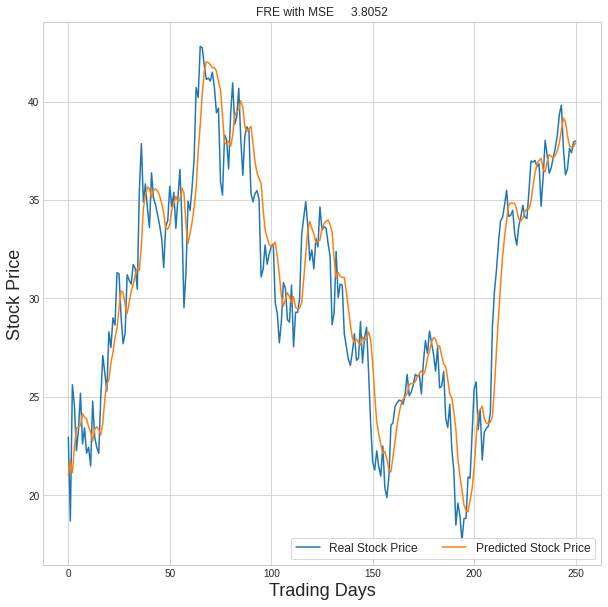

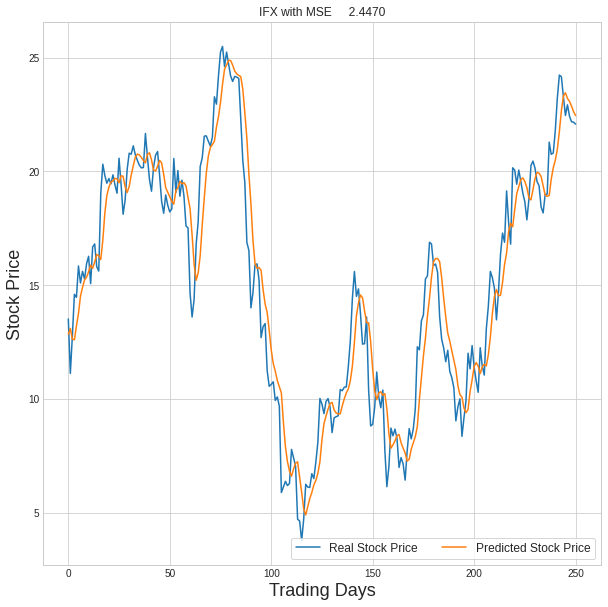

In [ ]:
pred_result1 = {}
MSE_GRU = 0
for i in stocks:
    y_true = scaler[i].inverse_transform(testset[i]["y"].reshape(-1,1))
    y_pred = scaler[i].inverse_transform(regressorGRU.predict(testset[i]["X"]))
    MSE = mean_squared_error(y_true, y_pred)
    MSE_GRU += MSE
    pred_result1[i] = {}
    pred_result1[i]["True"] = y_true
    pred_result1[i]["Pred"] = y_pred
    plt.figure(figsize=(10,10))
    plt.title("{} with MSE {:10.4f}".format(i,MSE))
    plt.xlabel('Trading Days', fontsize=18)
    plt.ylabel('Stock Price', fontsize=18)
    plt.plot(y_true, label = "Real Stock Price")
    plt.plot(y_pred, label = "Predicted Stock Price")
    
    plt.legend(ncol=2, loc="lower right",frameon=True,shadow=False,fontsize=12)
    plt.show()

In [ ]:
print("The MSE of the GRU =" + str(MSE_GRU))
print("The MSE of the LSTM =" + str(MSE_LSTM))

The MSE of the GRU =530.8533681761696
The MSE of the LSTM =326.75204446199643


# Investment Strategy

In [ ]:
#LSTM Investment Simulation
budget = 1000000

def simulate_investment():
  number_of_stock = 1
  portfolio_over_time = [budget]

  for i in range(1,251):
    price_change = {}
    for stock in stocks:
      price_change[stock] = pred_result[stock]["Pred"][i] / pred_result[stock]["True"][i - 1]
    this_day_best = find_best(price_change=price_change)
    if this_day_best != 0:
      portfolio_over_time.append(( portfolio_over_time[-1] / pred_result[this_day_best]["True"][i-1] ) * pred_result[this_day_best]["True"][i])
    else: 
      portfolio_over_time.append(portfolio_over_time[-1])
  return portfolio_over_time

def find_best(price_change :dict):
  price_change = sorted(price_change.items(), key=lambda x:x[1])
  if price_change[-1][1]<1:
    return 0
  return price_change[-1][0]

In [ ]:
#GRU Investment Simulation
budget1 = 1000000

def simulate_investment1():
  number_of_stock1 = 1
  portfolio_over_time1 = [budget1]

  for i in range(1,251):
    price_change1 = {}
    for stock in stocks:
      price_change1[stock] = pred_result1[stock]["Pred"][i] / pred_result1[stock]["True"][i - 1]
    this_day_best1 = find_best1(price_change1=price_change1)
    if this_day_best1 != 0:
      portfolio_over_time1.append(( portfolio_over_time1[-1] / pred_result1[this_day_best1]["True"][i-1] ) * pred_result1[this_day_best1]["True"][i])
    else: 
      portfolio_over_time1.append(portfolio_over_time1[-1])
  return portfolio_over_time1

def find_best1(price_change1 :dict):
  price_change1 = sorted(price_change1.items(), key=lambda x:x[1])
  if price_change1[-1][1]<1:
    return 0
  return price_change1[-1][0]

In [ ]:
#Buy and Hold Simulation
budget2 = 1000000
def simulate_investment2():
  number_of_stock2 = len(stocks)
  portfolio_over_time2 = [budget2]
  budget_per_stock = budget2 / number_of_stock2
  shares_per_stock = {}
  for stock in stocks:
    shares_per_stock[stock] = budget_per_stock / pred_result1[stock]["True"][0]

  for i in range(1,251):
    new_budget = 0
    for stock in stocks:
      new_budget = new_budget + pred_result1[stock]["True"][i] * shares_per_stock[stock]
    portfolio_over_time2.append(new_budget) 

  return portfolio_over_time2 

In [ ]:
print(simulate_investment())
print(simulate_investment1())
print(simulate_investment2())

[1000000, array([909664.05808919]), array([1254145.19009133]), array([1172495.29280861]), array([1268967.33534248]), array([1389975.50635306]), array([1324322.25713156]), array([1271555.79652711]), array([1257269.21029558]), array([1258421.3328443]), array([1443983.45850805]), array([1383076.44439601]), array([1594867.23551517]), array([947057.53929358]), array([855296.15402962]), array([856665.50080805]), array([667664.29826234]), array([727925.48310201]), array([678620.6398459]), array([737512.47790714]), array([747099.47271227]), array([763534.24631363]), array([821056.73759643]), array([808010.36644596]), array([932929.27326316]), array([935985.62340935]), array([869762.24211993]), array([775359.00649733]), array([813734.20079678]), array([943442.5449078]), array([904164.9694698]), array([857711.64995121]), array([923857.0642495]), array([939348.52797882]), array([962846.86205448]), array([1039607.36959668]), array([1071460.37474537]), array([987503.10691173]), array([980172.839029

/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


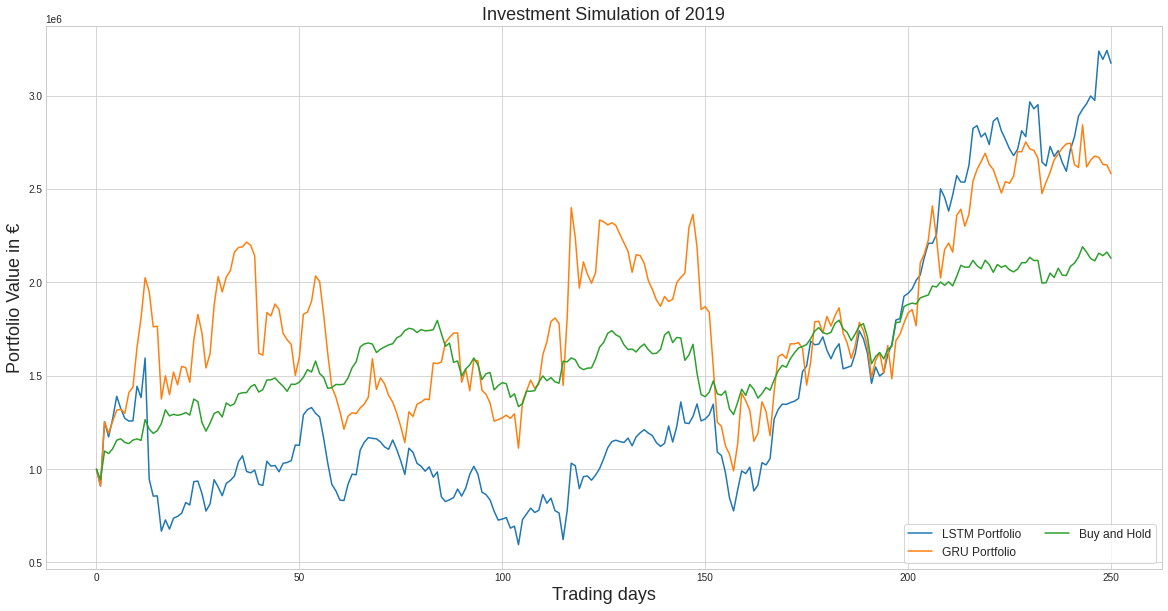

In [ ]:
plt.style.use('seaborn-whitegrid')
def plot_portfolio():
    LSTM_Portfolio = simulate_investment()
    GRU_Portfolio = simulate_investment1()
    Buy_and_Hold = simulate_investment2()
    plt.figure(figsize=(20, 10))
    plt.title('Investment Simulation of 2019', fontsize=18)
    plt.xlabel('Trading days', fontsize=18)
    plt.ylabel('Portfolio Value in €', fontsize=18)
    plt.plot(LSTM_Portfolio, label = "LSTM Portfolio")
    plt.plot(GRU_Portfolio, label = "GRU Portfolio")
    plt.plot(Buy_and_Hold, label = "Buy and Hold")
    plt.legend(ncol=2, loc="lower right",frameon=True,shadow=False,fontsize=12)
    
    plt.show()
plot_portfolio()